## Amazon Textract Queries

Amazon Textract Queries provides customers the flexibility to easily specify and extract valuable pieces of information that are important for their business process from a document or collection of documents. Customers who know the critical fields they need to extract from a document, can pass that context to Textract Queries. 

Providing this context means, Textract can focus on the parts of the document that are most important and take advantage of visual, spatial, and textual cues to extract the data requested. With this additional context, customers no longer need to lookout for an exact match field name, or maintain a list of synonyms across documents. 

With Textract Queries, customers can extract with high accuracy regardless of the how the data is laid out in a document structure such as forms, tables, and checkboxes, or housed within nested sections within a document.
 
By using Textract Queries, customers do not write additional post-processing code to figure out which key-value or table value corresponds to what they need, or require to train and integrate with custom models to detect the implied fields such as name, and address within the documents or require manual inputs to infer the extracted data. With Textract Queries’s flexibility to specify and extract valuable pieces of information that are important for various stages in a business process, customers can scale up their workflows, drive automation, and efficiencies in the underlying business processes more quickly and easily. 

### Setup

Install boto3 and the textract-response-parser.


In [1]:
!python -m pip -q install boto3 amazon_textract_response_parser --upgrade

You should consider upgrading via the '/Users/schadem/.pyenv/versions/amazon-textract-code-samples/bin/python -m pip install --upgrade pip' command.


In [3]:
image_filename = "paystub.jpg"

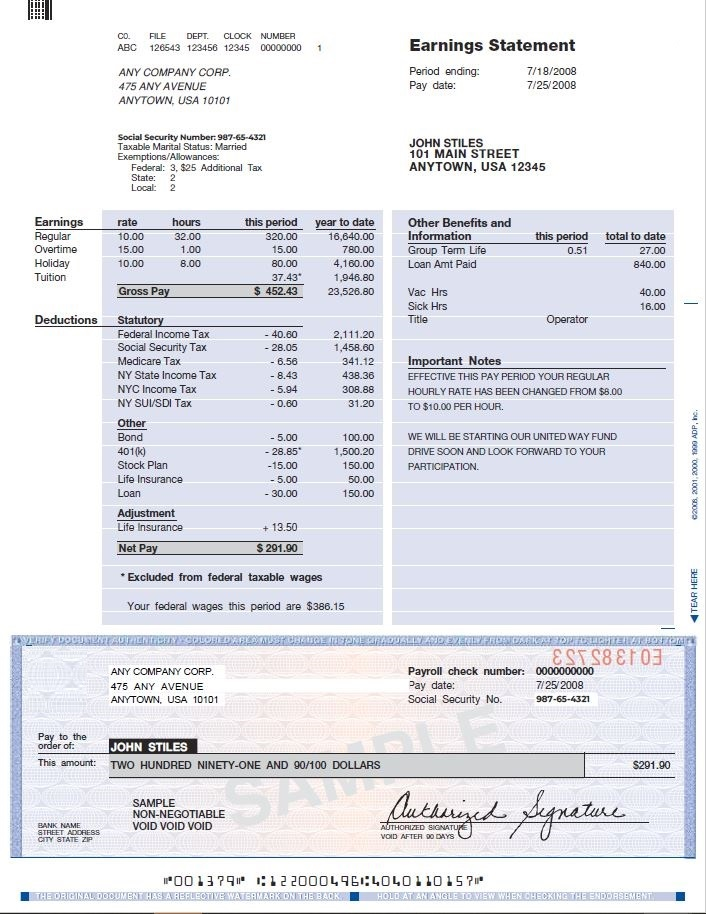

In [4]:
from IPython.display import Image
Image(filename=image_filename)

In [5]:
import boto3
import json

#create a Textract Client
textract = boto3.client('textract')
#Document
documentName = image_filename

## Call the AnalyzeDocument api with the Queries parameter. 

In [6]:
response = None
with open(image_filename, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Textract AnalyzeDocument by passing a document from local disk
response = textract.analyze_document(
    Document={'Bytes': imageBytes},
    FeatureTypes=["QUERIES"],
    QueriesConfig={
        "Queries": [{
            "Text": "What is the year to date gross pay",
            "Alias": "PAYSTUB_YTD_GROSS"
        },
        {
            "Text": "What is the current gross pay?",
            "Alias": "PAYSTUB_CURRENT_GROSS"
        },
        {
            "Text": "What is the current net pay?",
            "Alias": "PAYSTUB_CURRENT_NET"
        },
        {
            "Text": "What is the current social security tax?",
            "Alias": "PAYSTUB_CURRENT_SOCIAL_SECURITY_TAX"
        },
        {
            "Text": "How much is the current medicare?",
            "Alias": "PAYSTUB_MEDICARE_TAX"
        },
        {
            "Text": "What is the vacation hours balance?",
            "Alias": "PAYSTUB_VACATION_HOURS"
        },
        {
            "Text": "What is the sick hours balance?",
            "Alias": "PAYSTUB_SICK_HOURS"
        },
        {
            "Text": "What is the employee name?",
            "Alias": "PAYSTUB_EMPLOYEE_NAME"
        }]
    })


The response does include all OCR WORDS and LINES, geometry information, confidence scores.

For this demo we just print out the information we did query for.

If we had added the FORMS and/or TABLES Feature Types, the information of those would be part of the response as well, making it easy to add QUERIES to any existing workflow.

## Parsing the response

The amazon-textract-response-parser library makes it easy to extract the answers to the questions from the Textract JSON schema

In [7]:
import trp.trp2 as t2

In [8]:
d = t2.TDocumentSchema().load(response)
page = d.pages[0]

# get_query_answers returns a list of [query, alias, answer]
query_answers = d.get_query_answers(page=page)
for x in query_answers:
    print(f"{image_filename},{x[1]},{x[2]}")


paystub.jpg,PAYSTUB_CURRENT_SOCIAL_SECURITY_TAX,-28.05
paystub.jpg,PAYSTUB_EMPLOYEE_NAME,JOHN STILES
paystub.jpg,PAYSTUB_CURRENT_NET,$ 291.90
paystub.jpg,PAYSTUB_YTD_GROSS,23,526.80
paystub.jpg,PAYSTUB_VACATION_HOURS,
paystub.jpg,PAYSTUB_MEDICARE_TAX,6.56
paystub.jpg,PAYSTUB_CURRENT_GROSS,$ 452.43
paystub.jpg,PAYSTUB_SICK_HOURS,16.00


### Tabulate allows for visualization of the response in a tabular form

In [9]:
!python -m pip install tabulate

You should consider upgrading via the '/Users/schadem/.pyenv/versions/amazon-textract-code-samples/bin/python -m pip install --upgrade pip' command.


In [10]:
from tabulate import tabulate
print(tabulate(query_answers, tablefmt="github"))

|------------------------------------------|-------------------------------------|-------------|
| What is the current social security tax? | PAYSTUB_CURRENT_SOCIAL_SECURITY_TAX | -28.05      |
| What is the employee name?               | PAYSTUB_EMPLOYEE_NAME               | JOHN STILES |
| What is the current net pay?             | PAYSTUB_CURRENT_NET                 | $ 291.90    |
| What is the year to date gross pay       | PAYSTUB_YTD_GROSS                   | 23,526.80   |
| What is the vacation hours balance?      | PAYSTUB_VACATION_HOURS              |             |
| How much is the current medicare?        | PAYSTUB_MEDICARE_TAX                | 6.56        |
| What is the current gross pay?           | PAYSTUB_CURRENT_GROSS               | $ 452.43    |
| What is the sick hours balance?          | PAYSTUB_SICK_HOURS                  | 16.00       |


## Example using question from a CSV file

We can use a CSV file to define the questions and aliases, which is easier to maintain and version compared to having them all in the Python code

In [11]:
!cat "paystub-questions_subset.csv"

In [12]:
queries_csv = "paystub-questions_subset.csv"

In [13]:
# assumes an alias for each question
import csv
queries = list()
with open(queries_csv, mode='r', encoding='utf-8-sig') as queries_csv_file:
    reader = csv.reader(queries_csv_file)
    for row in reader:
        queries.append({"Text": row[0].strip(), "Alias": row[1] })

In [14]:
response = None
with open(image_filename, 'rb') as document:
    image_bytes = bytearray(document.read())

    # Call Textract
    response = textract.analyze_document(
        Document={'Bytes': image_bytes},
        FeatureTypes=["QUERIES"],
        QueriesConfig={
            "Queries": queries
        })


In [15]:
d = t2.TDocumentSchema().load(response)
page = d.pages[0]

query_answers = d.get_query_answers(page=page)

print(tabulate(query_answers, tablefmt="github"))

|------------------------------------|--------------------------|----------------------------------------------------------------------------------------------------|
| What is the State Filing Status?   | PAYSTUB_STATE_FILING     | 2                                                                                                  |
| What is the Pay Period Start Date? | PAYSTUB_START_DATE       |                                                                                                    |
| What is the Company Address?       | PAYSTUB_EMPLOYER_ADDRESS | 475 ANY AVENUE ANYTOWN, USA 10101                                                                  |
| What is the Pay Date?              | PAYSTUB_PAY_DATE         | 7/25/2008                                                                                          |
| What is the Employee Address?      | PAYSTUB_EMPLOYEE_ADDRESS | 101 MAIN STREET ANYTOWN, USA 12345                                                                 